## This notebook will get model outputs from the Community Firn Model to compare to the Summit data
### The notebook specifically runs through:
   #### -the modeled compaction rates for each instrument
   #### -the root mean square error of the modeled compaction rates
   #### -the modeled Summit core data for each instrument

In [1]:
### Import necessary python packages and CFM code.
# import statsmodels.api as sm
import h5py as h5
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import scipy as sp
import pandas as pd
import netCDF4 as nc
import sys
import os
import pickle
import seaborn as sns 
import glob
import time
import json
import shutil
import xarray as xr
import copy
import tables as tb
import datetime
import calendar
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # turn off future warning for frame.append
pd.options.mode.chained_assignment = None # turn off chained assignment warning, default = 'warn'

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

from sklearn.metrics import mean_squared_error
import math
np.seterr(invalid='ignore')

SPY = 365.25*24*3600

try:
    sys.path.append('/Users/dswan1/Downloads/CFM/CommunityFirnModel/CFM_main')
except:
    pass

from firn_density_nospin import FirnDensityNoSpin
from siteClimate_from_RCM import getClimate #get data from RCM
from RCMpkl_to_spin import makeSpinFiles

In [2]:
# Default Settings for figures
sb=True
if sb:
    sns.set()
    sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 1.5})
#     sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set_style("whitegrid",{"xtick.top":True, "xtick.bottom":True,"ytick.left":True, "ytick.right":True})
# plt.style.use('seaborn-notebook')

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams.update({'figure.autolayout': True})
fontsz = 20
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rcParams['axes.titlesize'] = 22
plt.rcParams["axes.labelsize"] = 22
plt.rcParams['figure.figsize'] = [10, 8]
palette = sns.color_palette()

In [3]:
def toYearFraction(date):
    '''
    convert datetime to decimal date 
    '''
    def sinceEpoch(date): # returns seconds since epoch
        return calendar.timegm(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime.datetime(year=year, month=1, day=1)
    startOfNextYear = datetime.datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

def decyeartodatetime(din):
    start = din
    rem, year = np.modf(din)
    base = datetime.datetime(int(year), 1, 1)
    result = base + datetime.timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    result2 = result.replace(second=0, microsecond=0)
    return result2

In [4]:
R          = 8.314                          # gas constant used to calculate Arrhenius's term
S_PER_YEAR = 31557600.0                     # number of seconds in a year
spy = S_PER_YEAR
RHO_1      = 550.0                          # cut off density for the first zone densification (kg/m^3)
RHO_2      = 815.0                          # cut off density for the second zone densification (kg/m^3)
RHO_I      = 917.0                          # density of ice (kg/m^3)
RHO_I_MGM  = 0.917                          # density of ice (g/m^3)
RHO_1_MGM  = 0.550                          # cut off density for the first zone densification (g/m^3)
GRAVITY    = 9.8                            # acceleration due to gravity on Earth
K_TO_C     = 273.15                         # conversion from Kelvin to Celsius
BDOT_TO_A  = S_PER_YEAR * RHO_I_MGM         # conversion for accumulation rate
RHO_W_KGM  = 1000.                          # density of water
P_0 = 1.01325e5

### Look at the Physics Schemes for Summit Data

#### You will need to change this cell to fit the lat/lon values and the filename prefix that you want

In [5]:
lat_int = 72.5 # latitude of interest
lon_int = -38.75 #longitude
# data_source = 'CFM_smetinput'
data_source = 'MERRA2_CLIM_df'

lat_val = lat_int
lon_val = lon_int

spin_date_st = 1980.0
spin_date_end = 2020.0

In [6]:
try:
    summit_df = pd.read_pickle(f'../Summit_compaction.pkl')
except:
    summit_df = pd.read_pickle(f'C:/Users/dswan1/Downloads/CFM/firncover/Summit_compaction.pkl')
try:
    compaction_df = pd.read_pickle(f'../compaction_df.pkl')
except:
    compaction_df = pd.read_pickle(f'C:/Users/dswan1/Downloads/CFM/firncover/compaction_df.pkl')

try:
    df_daily = pd.read_pickle(f'C:/Users/dswan1/Downloads/CFM/CommunityFirnModel/CFM_main/MERRA2_CLIM_df_{lat_val}_{lon_val}.pkl')
except:
    df_daily = pd.read_pickle(f'/Users/cdsteve2/research/firn/CommunityFirnModel/CFM_main/IDS/pickle/MERRA2_CLIM_df_{lat_int}_{lon_int}.pkl')

In [7]:
t_adjust = 3
df_daily_adjusted = df_daily.copy()
df_daily_adjusted['TS'] = df_daily_adjusted['TS'] + t_adjust

In [8]:
# Load the model outputs

fns = ['KuipersMunneke2015','GSFC2020']
# fns = ['HLdynamic', 'Li2011']
# fns = ['Morris2014', 'Crocus']
# fns = ['GSFC2020']
# rvs = ['315']
rvs = [315,325]
# rd = {} #results dictionary
# for physics in fns:
#     for rv in rvs:
#         print(physics)
#         print(rv)
#         ff = f'CFMoutputs/CFMresults_{lat_val}_{lon_val}_{physics}_{rv}_{spin_date_end}/CFMresults.hdf5'
#         with h5.File(ff,'r') as open_fn: # Open the CFM results file
#             physics_rv = physics + '_' + str(rv)
#             print(physics_rv)
#             vars_list = list(open_fn.keys()) # Make a list of the variables stored in the file
#             # The first row in each of the model outputs is the initial condition, so we don't want that (i.e. start by using the data in 2nd row)
#             # The first column is the time step. So, we use index [1:,1:] on most of the variables to get just the data we want.
#             rd[physics_rv] = {}
#             rd[physics_rv]['model_time'] = open_fn['density'][1:,0]
#             rd[physics_rv]['depth'] = open_fn['depth'][1:,1:] # Put the depth data into a numpy array
#             rd[physics_rv]['density'] = open_fn['density'][1:,1:] # Put the density data into an array
#             rd[physics_rv]['temperature'] = open_fn['temperature'][1:,1:]
#             rd[physics_rv]['DIP'] = open_fn['DIP'][1:,1:]
#             rd[physics_rv]['Dcon'] = open_fn['Dcon'][1:,1:]
            
### Model output Plus t_adjust
rd2 = {} #results dictionary
for physics in fns:
    for rv in rvs:
        print('==========')
        print(physics)
        print(rv)
        ff2 = f'CFMoutputs/CFMresults_{lat_val}_{lon_val}_{physics}_{rv}_{spin_date_end}_Tplus{t_adjust}/CFMresults.hdf5'
        print(ff2)
        with h5.File(ff2,'r') as open_fn2: # Open the CFM results file
            physics_rv = physics + '_' + str(rv)
            print(physics_rv)
            print('==========')
            vars_list = list(open_fn2.keys()) # Make a list of the variables stored in the file
            # The first row in each of the model outputs is the initial condition, so we don't want that (i.e. start by using the data in 2nd row)
            # The first column is the time step. So, we use index [1:,1:] on most of the variables to get just the data we want.
            rd2[physics_rv] = {}
            rd2[physics_rv]['model_time'] = open_fn2['density'][1:,0]
            rd2[physics_rv]['depth'] = open_fn2['depth'][1:,1:] # Put the depth data into a numpy array
            rd2[physics_rv]['density'] = open_fn2['density'][1:,1:] # Put the density data into an array
            rd2[physics_rv]['temperature'] = open_fn2['temperature'][1:,1:]
            rd2[physics_rv]['DIP'] = open_fn2['DIP'][1:,1:]
            rd2[physics_rv]['Dcon'] = open_fn2['Dcon'][1:,1:]
            rd2[physics_rv]['Datetime'] = pd.to_datetime([decyeartodatetime(iii) for iii in rd2[physics_rv]['model_time']])

KuipersMunneke2015
315
CFMoutputs/CFMresults_72.5_-38.75_KuipersMunneke2015_315_2020.0_Tplus3/CFMresults.hdf5
KuipersMunneke2015_315
KuipersMunneke2015
325
CFMoutputs/CFMresults_72.5_-38.75_KuipersMunneke2015_325_2020.0_Tplus3/CFMresults.hdf5
KuipersMunneke2015_325
GSFC2020
315
CFMoutputs/CFMresults_72.5_-38.75_GSFC2020_315_2020.0_Tplus3/CFMresults.hdf5
GSFC2020_315
GSFC2020
325
CFMoutputs/CFMresults_72.5_-38.75_GSFC2020_325_2020.0_Tplus3/CFMresults.hdf5
GSFC2020_325


In [9]:
#The corresponding instrument number 

SumIds = compaction_df[compaction_df.sitename=='Summit'].index.get_level_values(0).unique()
SumIds

UInt64Index([30, 31, 32, 33, 41, 50], dtype='uint64', name='instrument_id')

In [10]:
# Find the compaction rates

idict = {}
for II in SumIds:
    DFI = compaction_df.loc[II]
    DFI['ccomp'] = DFI['compaction_borehole_length_m'].iloc[0] - DFI['compaction_borehole_length_m'] #ccomp = cummualtive compaction
    dt = (DFI.index[1] - DFI.index[0]).total_seconds()
    deltaL = -1*DFI['compaction_borehole_length_m'].diff()
    deltaL[deltaL>0.002] = np.nan
    DFI['deltaL'] = deltaL
    DFI['comp_rate_yr'] = DFI['deltaL']/dt*S_PER_YEAR
    idict[II] = DFI

Text(0.5, 1.0, 'Compaction Rate Instrument 30')

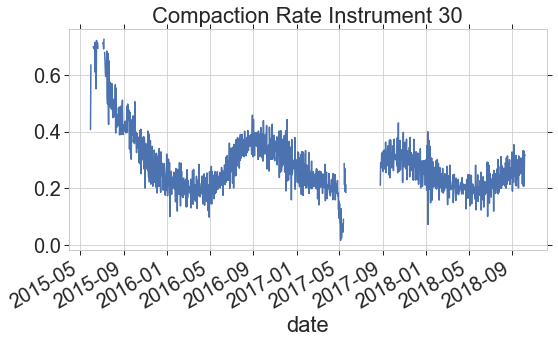

In [11]:
## Plot Compaction Rate for just Instrument 30

II = 30
f1,a1 = plt.subplots(figsize=(8,5))
d2 = idict[II]
d2['comp_rate_yr'].plot(ax=a1)
a1.set_title(f'Compaction Rate Instrument {II}')

# for physics_rv in rd.keys():
# within loop call getmodeledcompaction function
# a1.plot(compaction_modeled.index,compaction_modeled['comp_rate'],label=physics_rv)

In [12]:
# ## Plot Compaction Rates for all instruments

# for II in SumIds:
#     f1,a1 = plt.subplots(figsize=(8,5))
#     d2 = idict[II]
#     d2['comp_rate_yr'].plot(ax=a1)
#     a1.set_title(f'Compaction Rate Instrument {II}')

In [13]:
'''
use this to calculate compaction rates
st refers to start, i.e. first day of the experiment
top refers to the location of the upper part of the firn compaction instrument, which at summit was installed on the surface (0m depth)
bottom (or bot) refers to the location of the bottom of the borehole/compaction instrument
i at the beginning of a variable indicates it is an index
Dcon is the layer identification number
'''
S_PER_YEAR = 31557600.0

def getModeledCompaction(time_st,time_end,initial_top,initial_bot,model_run):

    # time_st = 2015.4
    # time_end = 2018.3
    # initial_top = 0
    # initial_bot = 15.73

    i_time_st = np.where(rd2[model_run]['model_time']>=time_st)[0][0] #index of the first time step in the experiment (i.e. what row # to choose to get model results for that time step)
    i_time_end = np.where(rd2[model_run]['model_time']<time_end)[0][-1] #index of the last time step in the experiment
    experiment_time = rd2[model_run]['model_time'][i_time_st:i_time_end+1] # +1 because python indexing is exclusive of last value 
    experiment_datetime = [decyeartodatetime(kk) for kk in experiment_time] # convemodel_run the model time (decimal date format) to a python date.

    depths_st = rd2[model_run]['depth'][i_time_st,:] #vector of model node depths at i_time_st

    i_top_st = np.where(depths_st>=initial_top)[0][0] #index at top, at stamodel_run of experiment
    i_bot_st = np.where(depths_st>=initial_bot)[0][0] #index where the bottom is, at stamodel_run of experiment

    dc_top = rd2[model_run]['Dcon'][i_time_st,i_top_st] # Dcon value of top
    dc_bot = rd2[model_run]['Dcon'][i_time_st,i_bot_st] # Dcon value of bottom
    ### (we will track the positions of these layers through time using Dcon)

    ### initialize vectors to fill in loop
    depths_top = np.zeros_like(experiment_time)
    depths_bot = np.zeros_like(experiment_time)

    ### loop through each time step in the model that overlaps with the time of the experiment
    for jj, et in enumerate(experiment_time): #jj is the loop indexer (i.e. 0,1,2...) and et is the value of experiment_time at jj
        i_mt = np.where(rd2[model_run]['model_time']==et)[0][0] #index of where the model time equals experiement time
        i_dc_top = np.where(rd2[model_run]['Dcon'][i_mt,:]==dc_top)[0][0] #index of the dc_top node at time et
        i_dc_bot = np.where(rd2[model_run]['Dcon'][i_mt,:]==dc_bot)[0][0] #index of the dc_bot node at time et
        depths_top[jj] = rd2[model_run]['depth'][i_mt,i_dc_top] #depth of top at time et
        depths_bot[jj] = rd2[model_run]['depth'][i_mt,i_dc_bot] #depth of bot at time et

    ### Create a pandas dataframe and add some more columns to get quantity we are interested in
    compaction_modeled = pd.DataFrame({'depths_top':depths_top, 'depths_bot': depths_bot},index=experiment_datetime)
    compaction_modeled['borehole_length'] = depths_bot - depths_top
    compaction_modeled['deltaL'] = -1*compaction_modeled['borehole_length'].diff()
    deltat = compaction_modeled.index.to_series().diff().mean().total_seconds() #average time, in seconds between model steps (5 days)
    compaction_modeled['comp_rate'] = compaction_modeled['deltaL']/deltat*S_PER_YEAR

    return compaction_modeled

In [14]:
### Calculate compaction rates from each model run, put them in a dataframe, and put each of those dataframes into a dictionary for storage
i30d = summit_df.loc[30]
st_top = 0
st_bot = i30d.hole_init_length[0]
stdf = toYearFraction(i30d.index[0])
endf = toYearFraction(i30d.index[-1]) #index [-1] indicating the end

modeled_comp_dict = {}

for model_name in rd2.keys():
    modeled_comp_dict[model_name]=getModeledCompaction(stdf,endf,st_top,st_bot,model_name)
    # print(modeled_comp_dict[model_name])

In [15]:
# ## plotting just instrument 30's modeled compaction rate

# II = 30
# f1,a1 = plt.subplots(figsize=(8,5))
# d2 = idict[II]
# d2['comp_rate_yr'].plot(ax=a1)
# a1.set_title(f'Modeled Compaction Rate Instrument {II}')

# # then a loop like this to get the model results into the plot (grabbing the correct dataframe from modeled_comp_dict)

# for model_name in rd2.keys():
#     comp_dataframe = modeled_comp_dict[model_name]
#     a1.plot(comp_dataframe.index,comp_dataframe['comp_rate'],label=model_name)
# a1.legend()

# # figfilename = f'Instrument_{II}_{lat_val}_{lon_val}_Modeled_Comp.png'
# # f1.savefig(figfilename)

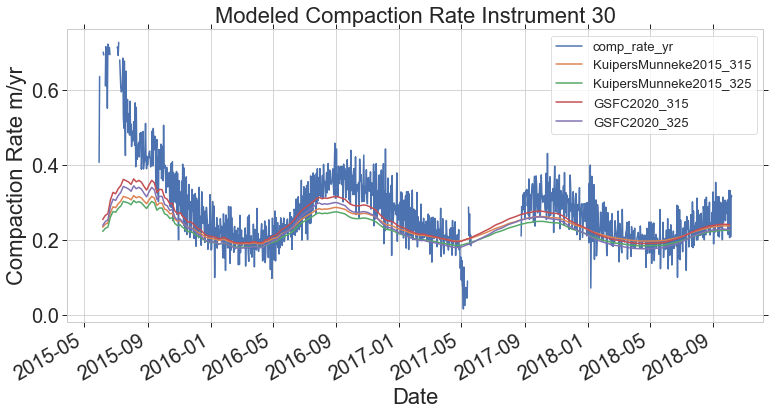

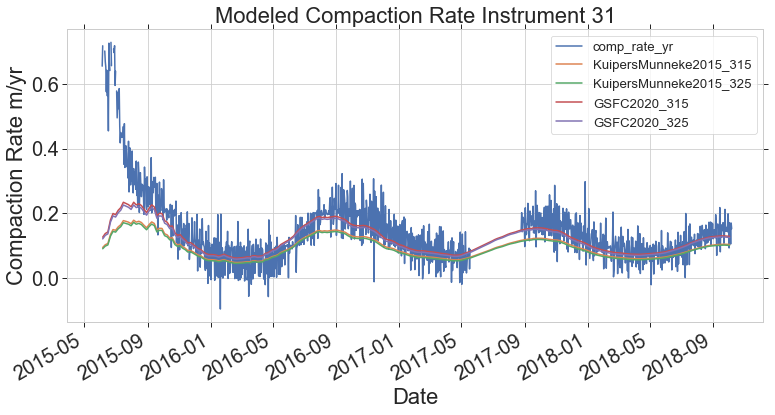

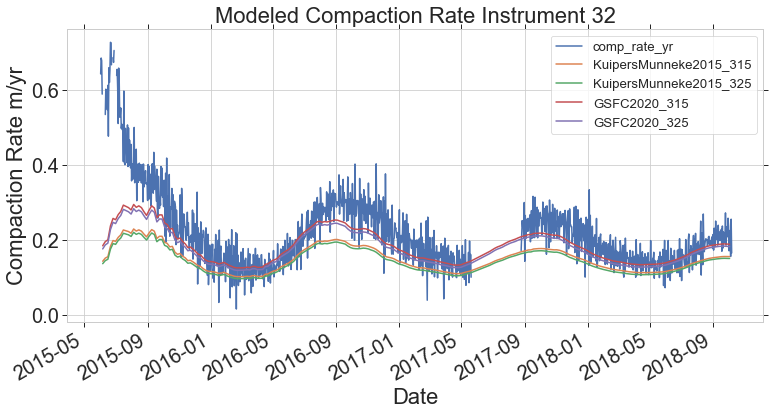

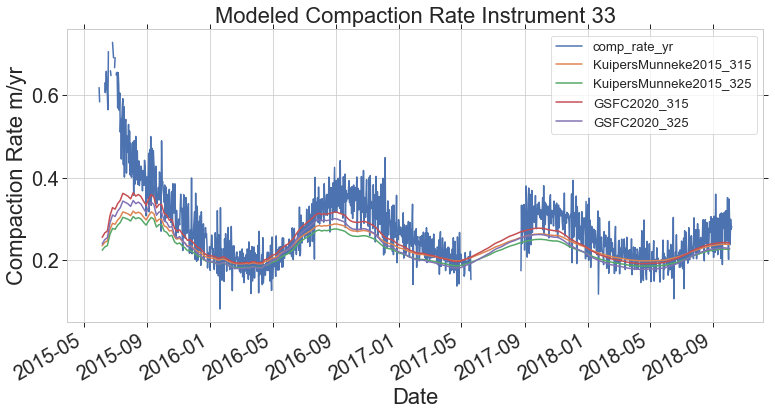

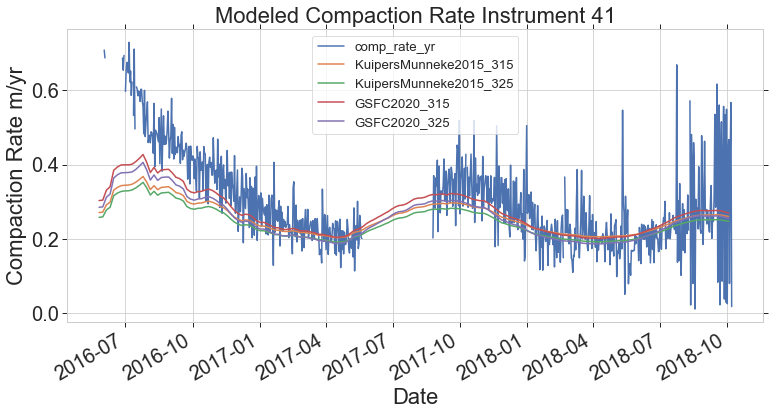

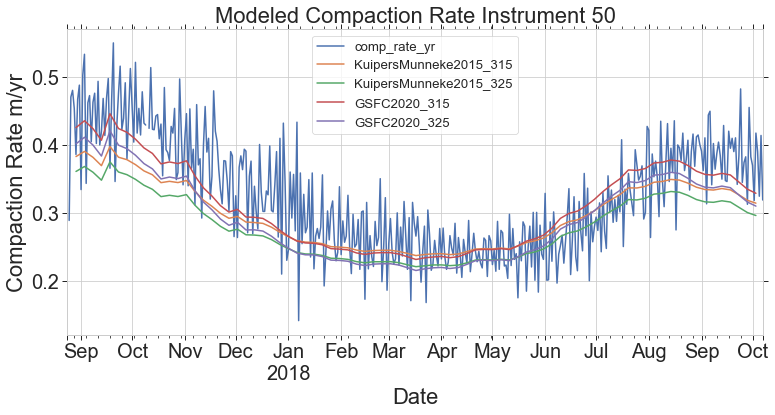

In [16]:
## Loop through all instruments for Summit data 
for II in SumIds:
    f1,a1 = plt.subplots(figsize=(11,6))
    compaction_observed = idict[II]
    compaction_observed['comp_rate_yr'].plot(ax=a1)
    a1.set_title(f'Modeled Compaction Rate Instrument {II}')
    
        ### calculate compaction rates from each model run, put them in a dataframe, and put each of those dataframes into a dictionary for storage
    # Summit_data = pd.read_pickle('/Users/cdsteve2/research/firn/firncover/Summit_compaction.pkl')
    INdf = summit_df.loc[II]
    st_top = 0
    st_bot = INdf.hole_init_length[0]
    stdf = toYearFraction(INdf.index[0])
    endf = toYearFraction(INdf.index[-1]) #index [-1] indicating the end

    modeled_comp_dict = {}

    for model_name in rd2.keys():
        modeled_comp_dict[model_name]=getModeledCompaction(stdf,endf,st_top,st_bot,model_name)
        # print(modeled_comp_dict[model_name])
        comp_dataframe = modeled_comp_dict[model_name]
        a1.plot(comp_dataframe.index,comp_dataframe['comp_rate'],label=model_name)
    a1.legend()
    a1.set_xlabel('Date')
    a1.set_ylabel('Compaction Rate m/yr')

    figfilename = f'Tplus{t_adjust}_Instrument_{II}_{lat_val}_{lon_val}_Modeled_Comp.png'
    f1.savefig(f'Summit_Figures/{figfilename}.png')

NRMSE Instrument 30, KuipersMunneke2015_315:
14.26 %
NRMSE Instrument 30, KuipersMunneke2015_325:
17.95 %
NRMSE Instrument 30, GSFC2020_315:
13.16 %
NRMSE Instrument 30, GSFC2020_325:
17.53 %
NRMSE Instrument 31, KuipersMunneke2015_315:
37.37 %
NRMSE Instrument 31, KuipersMunneke2015_325:
40.24 %
NRMSE Instrument 31, GSFC2020_315:
24.04 %
NRMSE Instrument 31, GSFC2020_325:
26.86 %
NRMSE Instrument 32, KuipersMunneke2015_315:
47.67 %
NRMSE Instrument 32, KuipersMunneke2015_325:
50.46 %
NRMSE Instrument 32, GSFC2020_315:
34.43 %
NRMSE Instrument 32, GSFC2020_325:
37.55 %
NRMSE Instrument 33, KuipersMunneke2015_315:
13.52 %
NRMSE Instrument 33, KuipersMunneke2015_325:
16.86 %
NRMSE Instrument 33, GSFC2020_315:
12.19 %
NRMSE Instrument 33, GSFC2020_325:
16.51 %
NRMSE Instrument 41, KuipersMunneke2015_315:
22.76 %
NRMSE Instrument 41, KuipersMunneke2015_325:
22.07 %
NRMSE Instrument 41, GSFC2020_315:
24.31 %
NRMSE Instrument 41, GSFC2020_325:
23.25 %
NRMSE Instrument 50, KuipersMunneke2015_

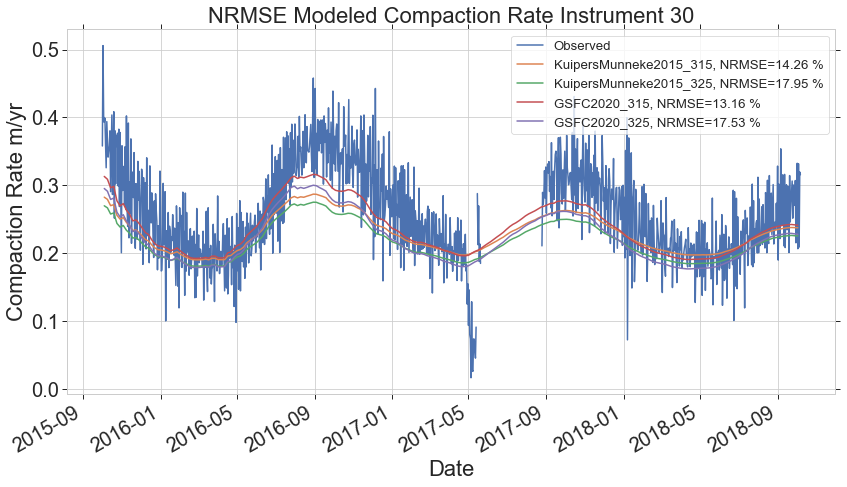

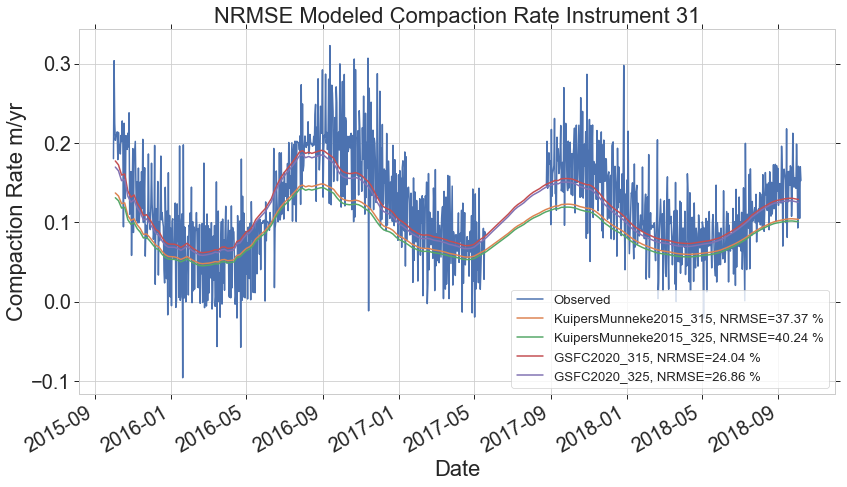

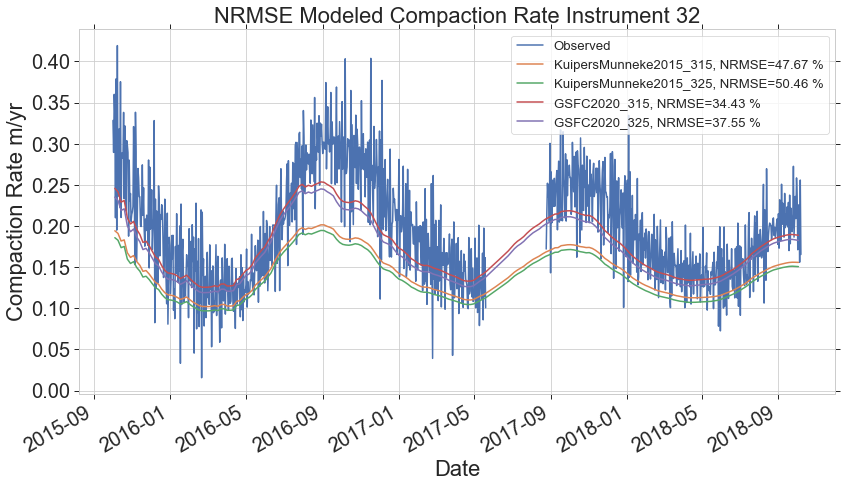

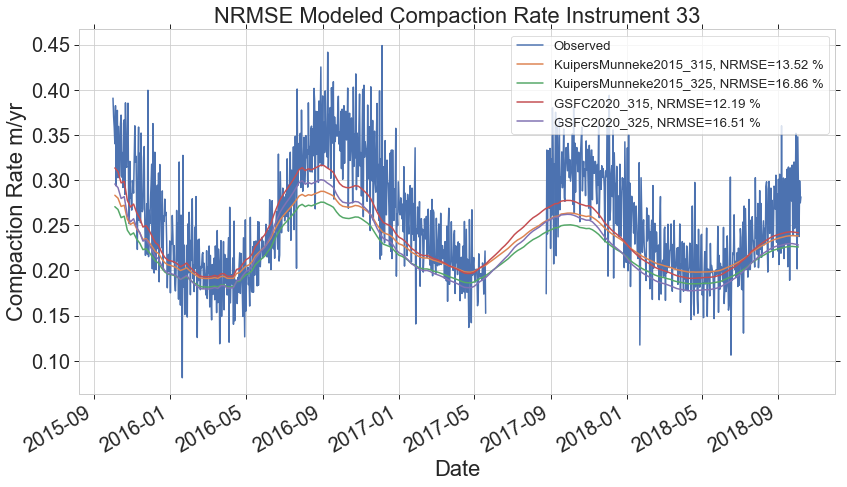

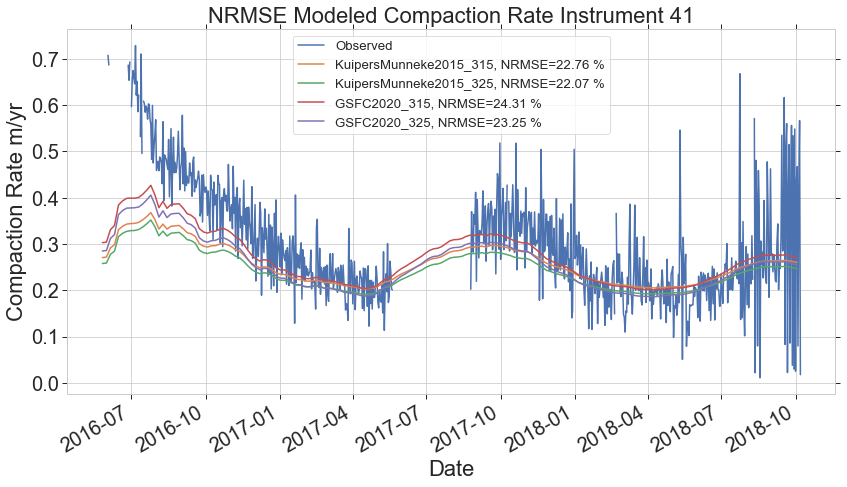

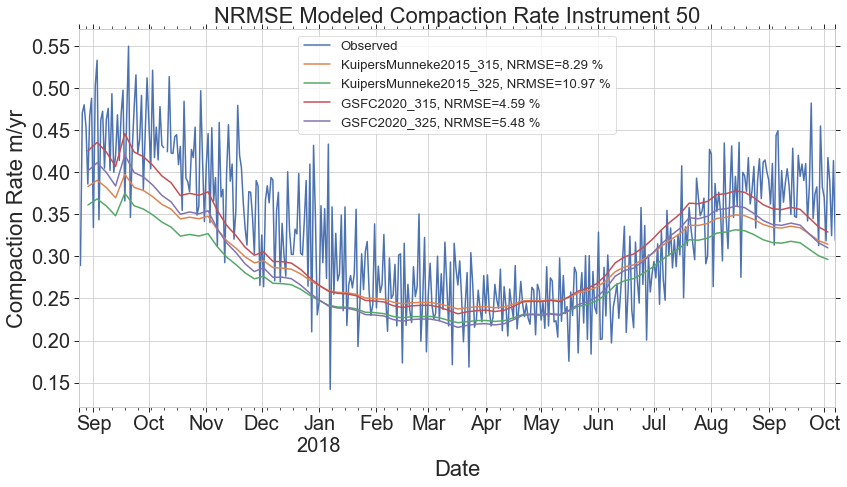

In [17]:
### RMSE for the modeled compaction rates

## Loop through all instruments for Summit data 
for II in SumIds:
    f1,a1 = plt.subplots(figsize=(12,7))
    compaction_observed = idict[II]
    y_measured_comp =compaction_observed['comp_rate_yr'].loc['2015-10':]  
    y_measured_comp.plot(ax=a1, label = f'Observed')
    a1.set_title(f'NRMSE Modeled Compaction Rate Instrument {II}')
    
        ### calculate compaction rates from each model run, put them in a dataframe, and put each of those dataframes into a dictionary for storage
    # Summit_data = pd.read_pickle('/Users/cdsteve2/research/firn/firncover/Summit_compaction.pkl')
    INdf = summit_df.loc[II]
    st_top = 0
    st_bot = INdf.hole_init_length[0]
    stdf = toYearFraction(INdf.index[0])
    endf = toYearFraction(INdf.index[-1]) #index [-1] indicating the end

    modeled_comp_dict = {}

    for model_name in rd2.keys():
        modeled_comp_dict[model_name]=getModeledCompaction(stdf,endf,st_top,st_bot,model_name)
        comp_dataframe = modeled_comp_dict[model_name].loc['2015-10':]
        y_modeled_comp = comp_dataframe['comp_rate']
        MSE_comp = np.square(np.subtract(y_measured_comp,y_modeled_comp)).mean() 
        RMSE_comp = math.sqrt(MSE_comp)
        NRMSE_comp = (RMSE_comp/y_measured_comp.mean())*100
        NRMSE_comp_round = round(NRMSE_comp, 2)
        print(f'NRMSE Instrument {II}, {model_name}:')
        print(f'{NRMSE_comp_round} %')
        a1.plot(comp_dataframe.index,comp_dataframe['comp_rate'],label = f'{model_name}, NRMSE={NRMSE_comp_round} %')
    a1.legend()
    a1.set_ylabel('Compaction Rate m/yr')
    a1.set_xlabel('Date')
    figfilename = f'Tplus{t_adjust}_NRMSE_{II}_{lat_val}_{lon_val}.png'
    f1.savefig(f'Summit_Figures/{figfilename}.png')

In [18]:
summit_df.groupby(level='instrument_id').head(1)

,,sitename,daynumber_YYYYMMDD,compaction_borehole_length_m,borehole_depth_top_m,borehole_depth_bottom_m,hole_init_length,hole_botfromsurf,hole_topfromsurf
instrument_id,date,,,,,,,,
30,2015-05-29,Summit,20150529,15.73,0.000000,15.730000,15.73,15.73,-0.0
31,2015-05-29,Summit,20150529,4.23,0.000000,4.230000,4.23,4.23,-0.0
32,2015-05-29,Summit,20150529,7.77,0.000000,7.770000,7.77,7.77,-0.0
33,2015-05-30,Summit,20150530,15.79,0.000907,15.790907,15.79,15.79,-0.0
41,2016-05-17,Summit,20160517,16.08,0.063996,16.143995,16.08,16.08,-0.0
50,2017-08-24,Summit,20170824,21.99,0.000000,21.990000,21.99,21.99,-0.0


## FirnCover Summit Core Data

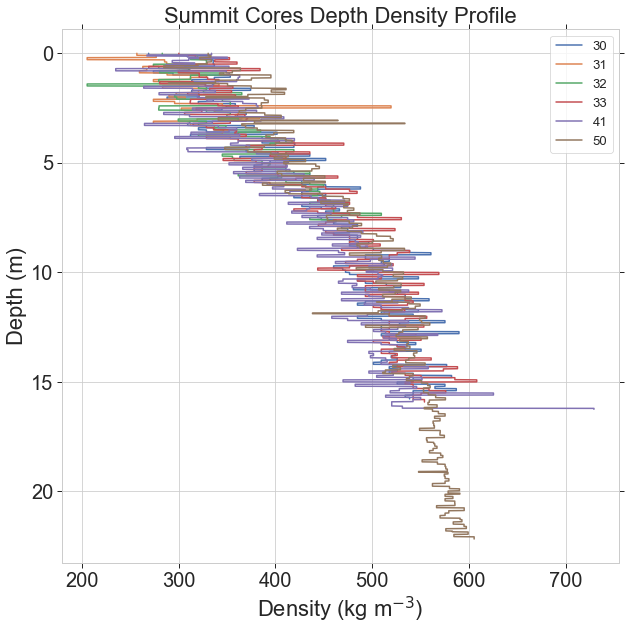

In [19]:
## plot the summit core density profile containing all instruments

f1,a1 = plt.subplots(figsize=(9,9))
Summit_cores = pd.read_pickle('FC_SummitCores.pkl')
core_numbers = Summit_cores.index.get_level_values(0).unique() #unique core numbers

xx = Summit_cores.loc[core_numbers[0]]

core_dict = {}    
for core_num in core_numbers:
    core_to_plot = Summit_cores.loc[core_num]
    a1.plot(core_to_plot['density'], core_to_plot['depth'], label = core_num)
a1.set_title(f'Summit Cores Depth Density Profile')
a1.set_xlabel('Density (kg m$^{-3}$)')
a1.set_ylabel('Depth (m)')
a1.invert_yaxis()
a1.legend()
figfilename = f'Tplus{t_adjust}_Core_Depth_Density.png'
f1.savefig(f'Summit_Figures/{figfilename}.png')

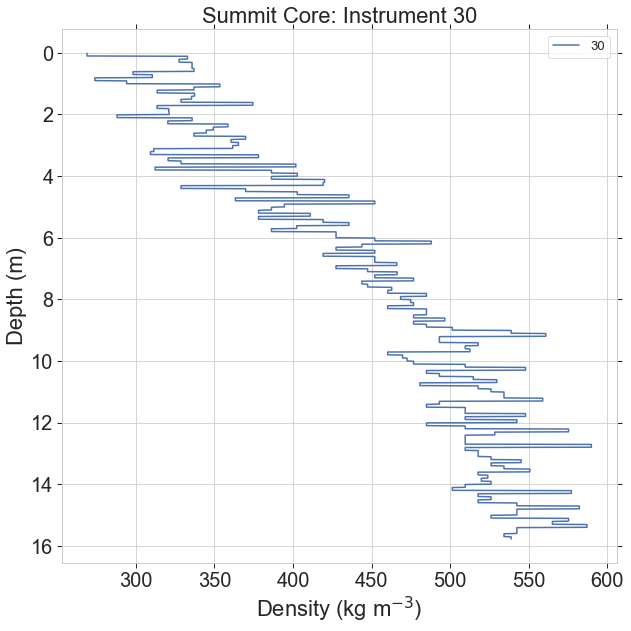

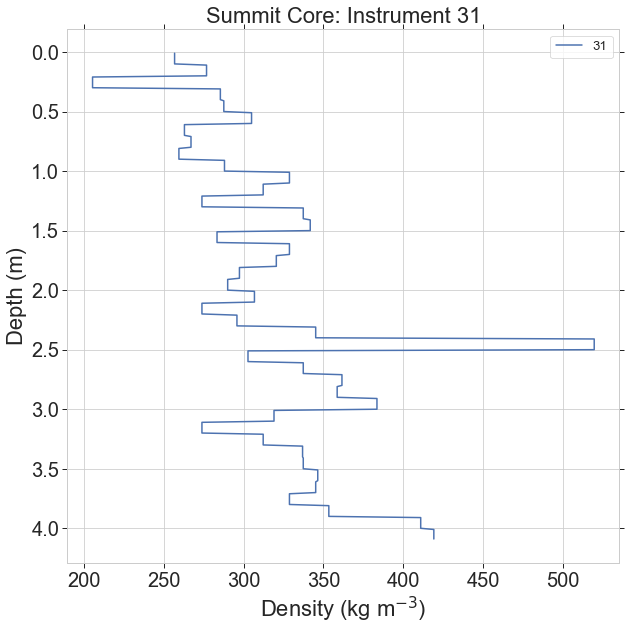

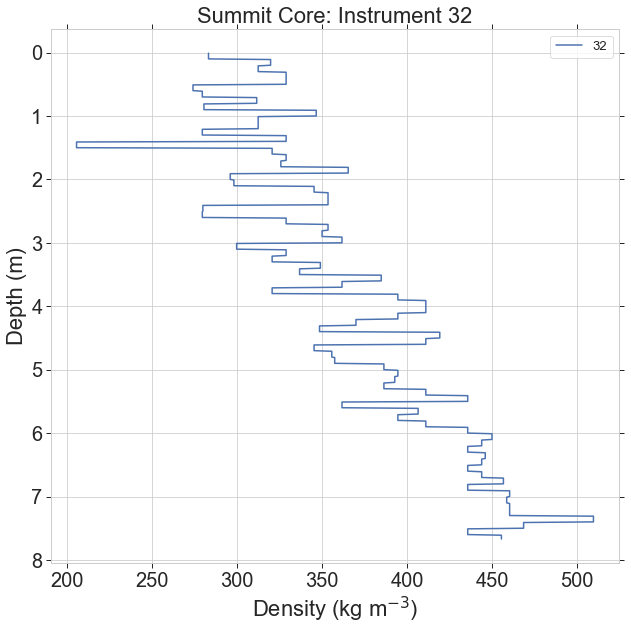

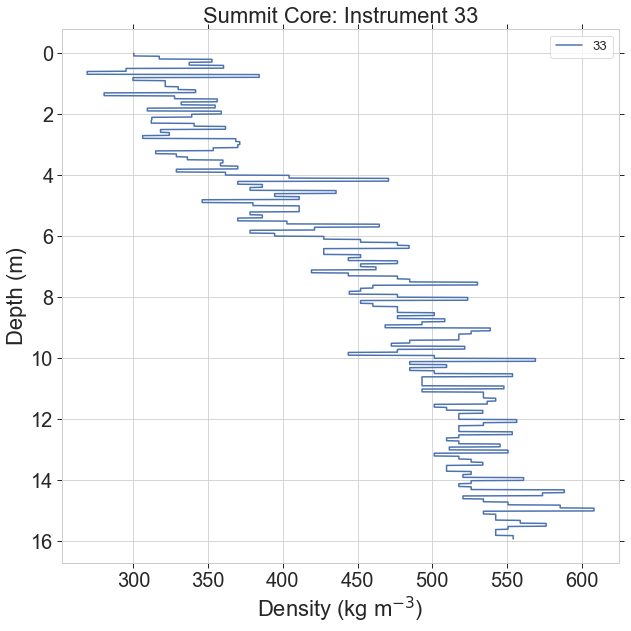

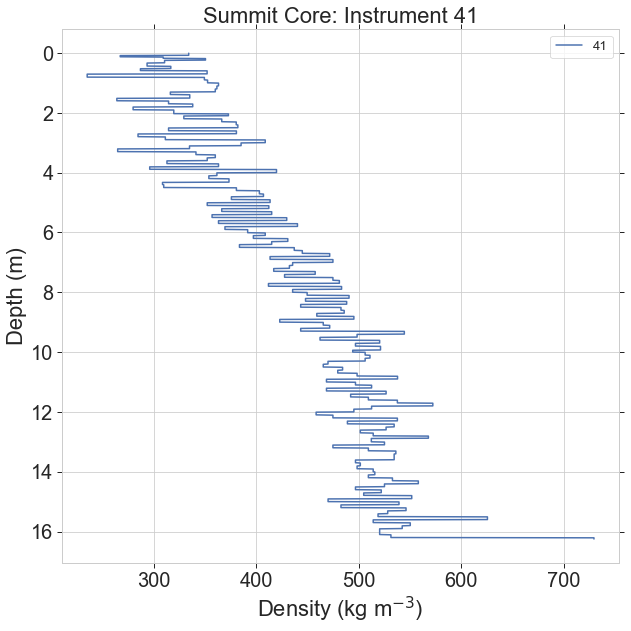

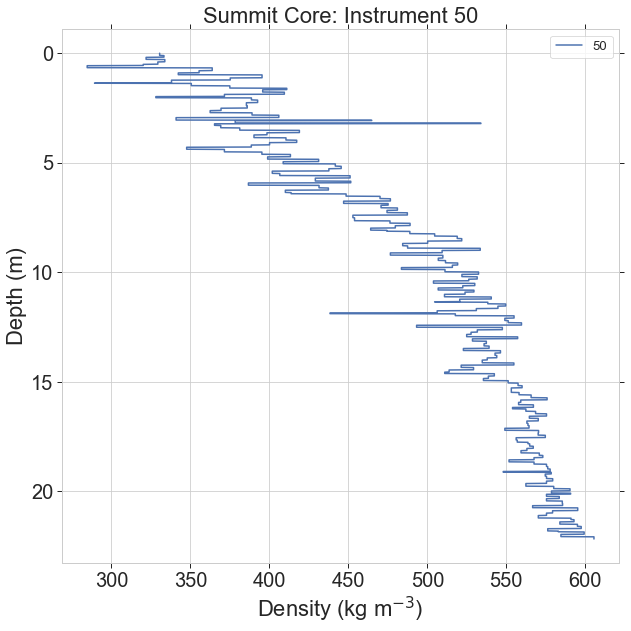

In [20]:
## Plot the summit core depth-density profiles individually 

Summit_cores = pd.read_pickle('FC_SummitCores.pkl')
core_numbers = Summit_cores.index.get_level_values(0).unique() #unique core numbers
core_dict = {}    
for core_num in core_numbers:
    f1,a1 = plt.subplots(figsize=(9,9))
    core_to_plot = Summit_cores.loc[core_num]
    a1.plot(core_to_plot['density'], core_to_plot['depth'], label = core_num)
    a1.set_title(f'Summit Core: Instrument {core_num}')
    a1.set_xlabel('Density (kg m$^{-3}$)')
    a1.set_ylabel('Depth (m)')
    a1.legend()
    figfilename = f'Tplus{t_adjust}_Core_{core_num}_Depth_Density.png'
    f1.savefig(f'Summit_Figures/{figfilename}.png')
    a1.invert_yaxis()

In [21]:
# def getModeledCores(time_st,time_end,initial_top,initial_bot,model_run):

def getModeledCores(core_date_dec,model_run):
    
    i_time_st = np.where(rd2[model_run]['model_time']>=core_date_dec)[0][0] #index of when model_time equals the core_date (or first model time step after)
    
    model_depth = rd2[model_run]['depth'][i_time_st,:] #vector of model node depths at i_time_st
    model_density = rd2[model_run]['density'][i_time_st,:] #vector of model node depths at i_time_st
        
    ### Create a pandas dataframe and add some more columns to get quantity we are interested in
    modeled_cores = pd.DataFrame({'depth':model_depth, 'density': model_density})
    
    return modeled_cores

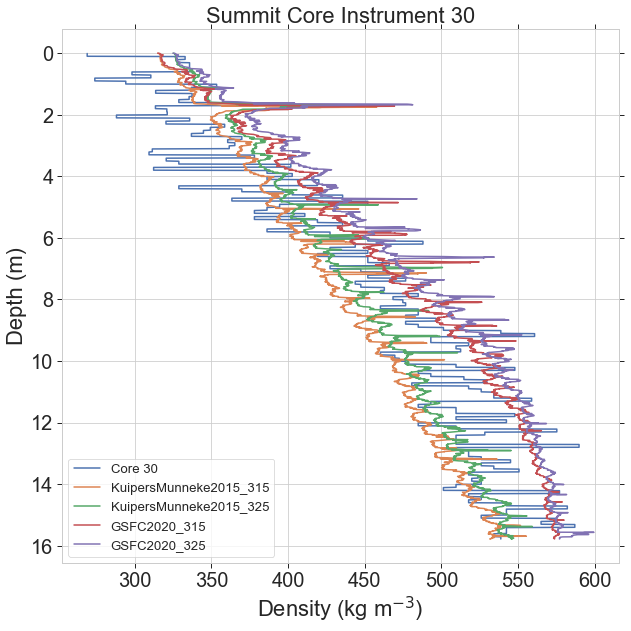

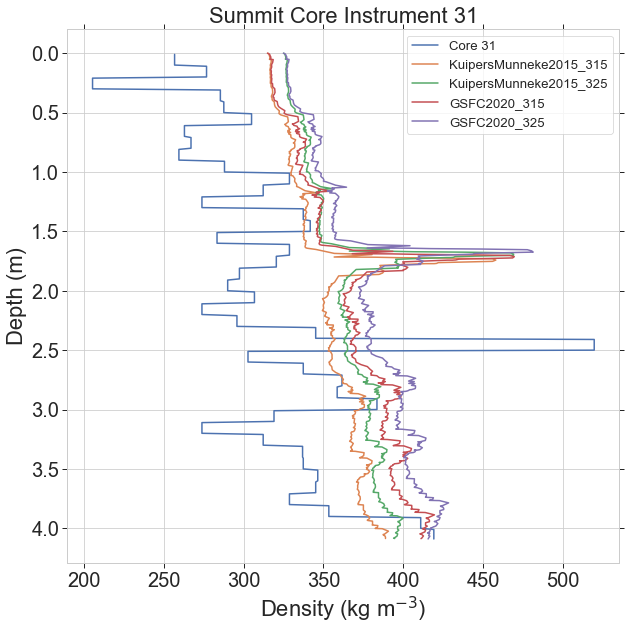

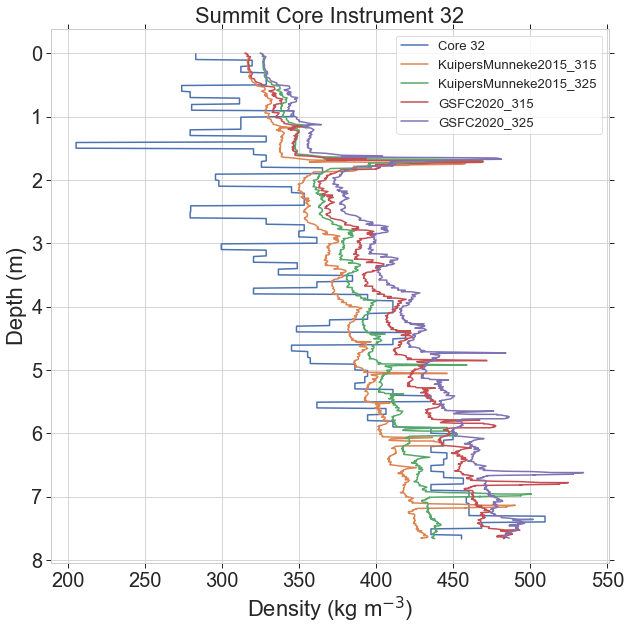

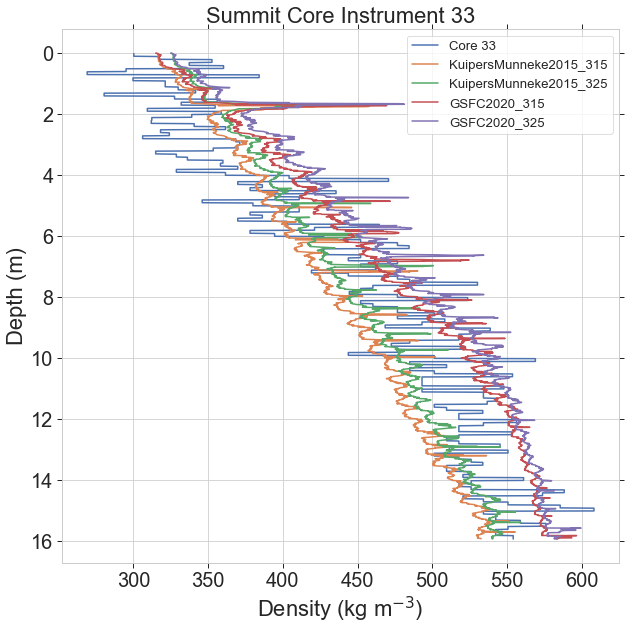

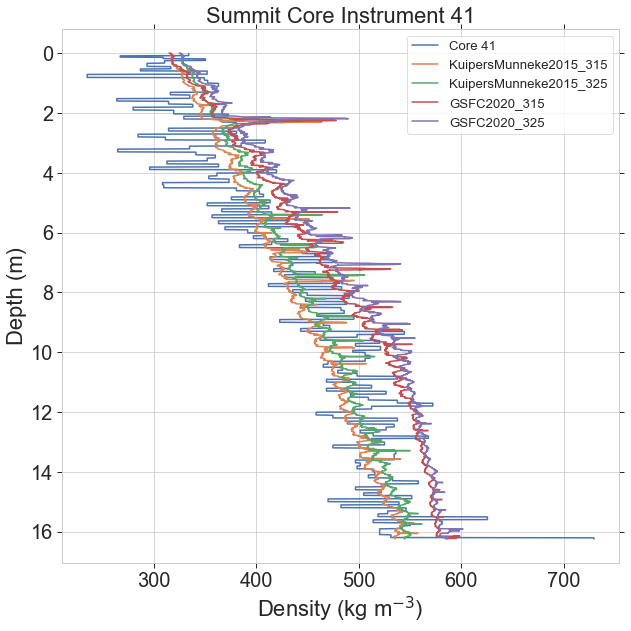

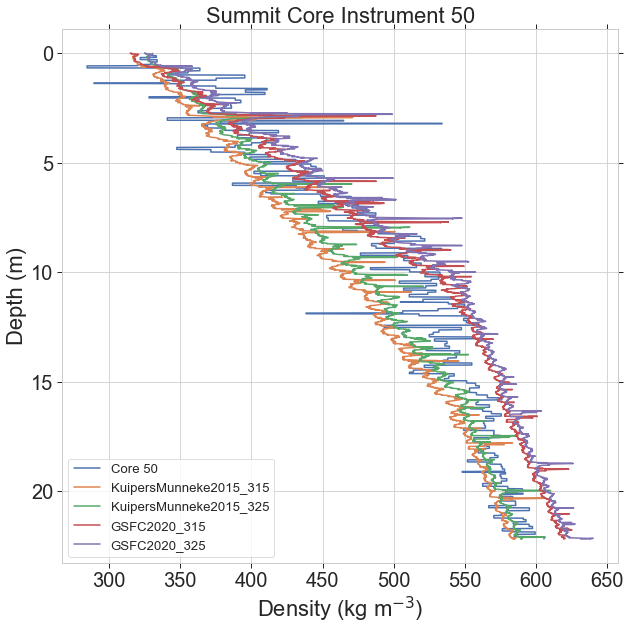

In [22]:
## Loop through all instruments for modeled Summit cores

Summit_cores = pd.read_pickle('FC_SummitCores.pkl')
core_numbers = Summit_cores.index.get_level_values(0).unique() #unique core numbers
core_dict = {}    
for core_num in core_numbers:
    f1,a1 = plt.subplots(figsize=(9,9))
    core_to_plot = Summit_cores.loc[core_num] 
    a1.plot(core_to_plot['density'], core_to_plot['depth'], label = f'Core {core_num}')
    a1.set_title(f'Summit Core Instrument {core_num}')
    a1.set_xlabel('Density (kg m$^{-3}$)')
    a1.set_ylabel('Depth (m)')
    
    core_maximum_depth = core_to_plot.depth.max() #(MS) let's get the maximum depth of the observed core, and we'll use that to only plot the model outputs to that depth.
        
    core_date = core_to_plot.index[0] #(MS) this is the date that the core was drilled, in YYYY-MM-DD format
    core_date_dec = toYearFraction(core_date) #(MS) this is the date that the core was drilled, in decimal date format, e.g. 2015.405
    
    modeled_cores_dict = {}

    for model_name in rd2.keys():
        modeled_cores_dict[model_name]=getModeledCores(core_date_dec,model_name)
        modeled_cores_dataframe = modeled_cores_dict[model_name] #(MS) this is now a dataframe with the depth and density for a particular model run        
        modeled_cores_toplot = modeled_cores_dataframe[modeled_cores_dataframe['depth']<core_maximum_depth]
        a1.plot( modeled_cores_toplot['density'], modeled_cores_toplot['depth'],label=model_name) #(MS) 'cores_dataframe' is already selecting just the dataframe for a particular model, so we can directly call the columns in that
    a1.legend()
    a1.invert_yaxis() #(MS) note that I put this at the same indentation level as f1,a1 = ...
    figfilename = f'Tplus{t_adjust}_Modeled_Core_{core_num}_Depth_Density.png'
    f1.savefig(f'Summit_Figures/{figfilename}.png')

NRMSE Instrument 30, KuipersMunneke2015_315:
8.18 %
NRMSE Instrument 30, KuipersMunneke2015_325:
7.4 %
NRMSE Instrument 30, GSFC2020_315:
8.35 %
NRMSE Instrument 30, GSFC2020_325:
9.77 %
NRMSE Instrument 31, KuipersMunneke2015_315:
17.63 %
NRMSE Instrument 31, KuipersMunneke2015_325:
19.69 %
NRMSE Instrument 31, GSFC2020_315:
20.33 %
NRMSE Instrument 31, GSFC2020_325:
22.98 %
NRMSE Instrument 32, KuipersMunneke2015_315:
10.31 %
NRMSE Instrument 32, KuipersMunneke2015_325:
11.21 %
NRMSE Instrument 32, GSFC2020_315:
12.48 %
NRMSE Instrument 32, GSFC2020_325:
14.88 %
NRMSE Instrument 33, KuipersMunneke2015_315:
8.47 %
NRMSE Instrument 33, KuipersMunneke2015_325:
7.87 %
NRMSE Instrument 33, GSFC2020_315:
8.49 %
NRMSE Instrument 33, GSFC2020_325:
9.76 %
NRMSE Instrument 41, KuipersMunneke2015_315:
8.34 %
NRMSE Instrument 41, KuipersMunneke2015_325:
8.67 %
NRMSE Instrument 41, GSFC2020_315:
11.47 %
NRMSE Instrument 41, GSFC2020_325:
13.05 %
NRMSE Instrument 50, KuipersMunneke2015_315:
7.15 %

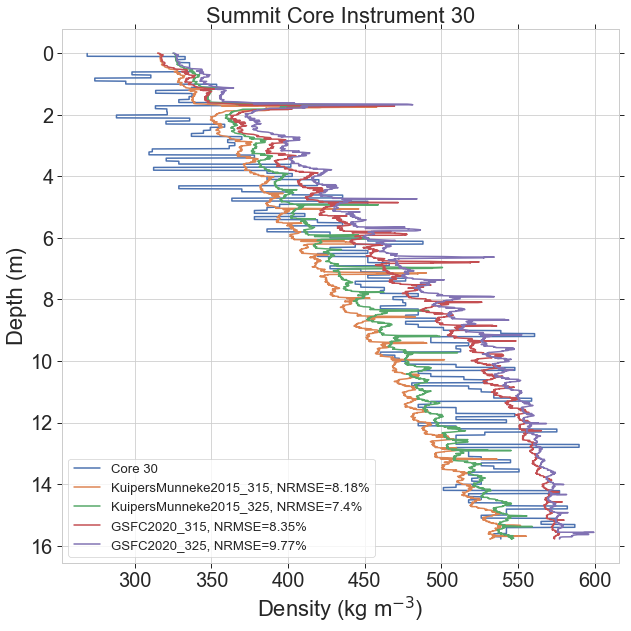

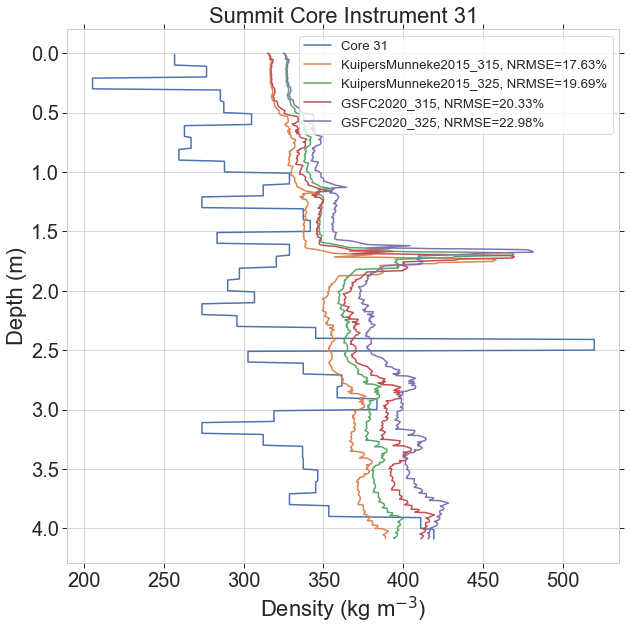

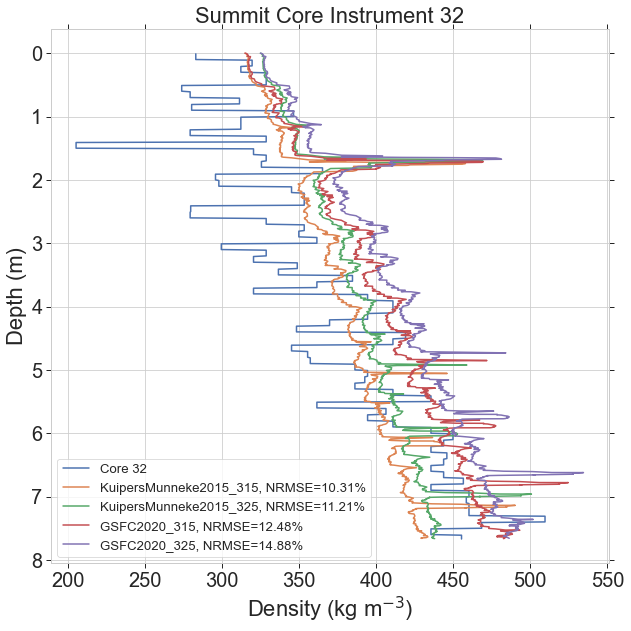

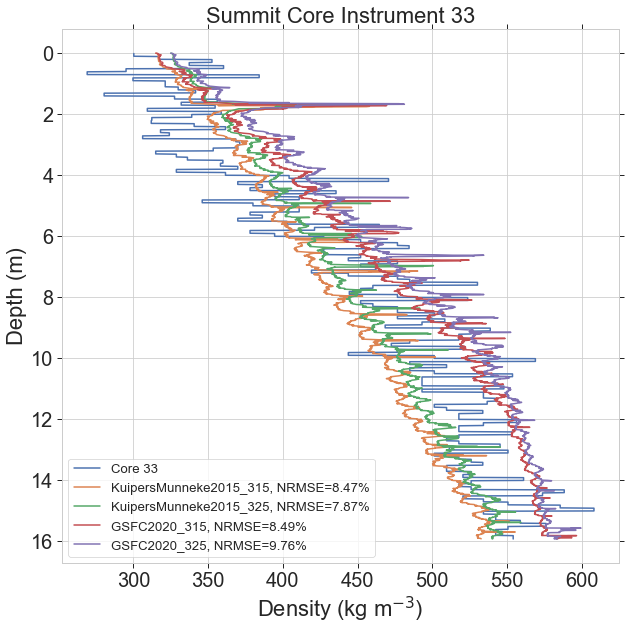

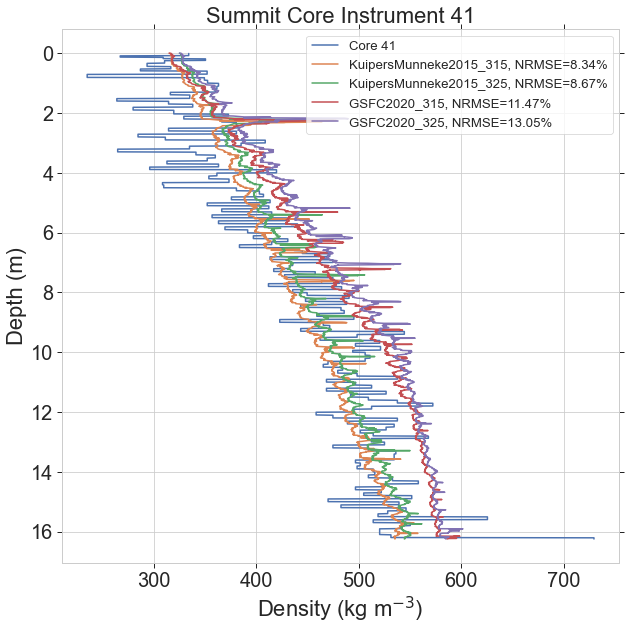

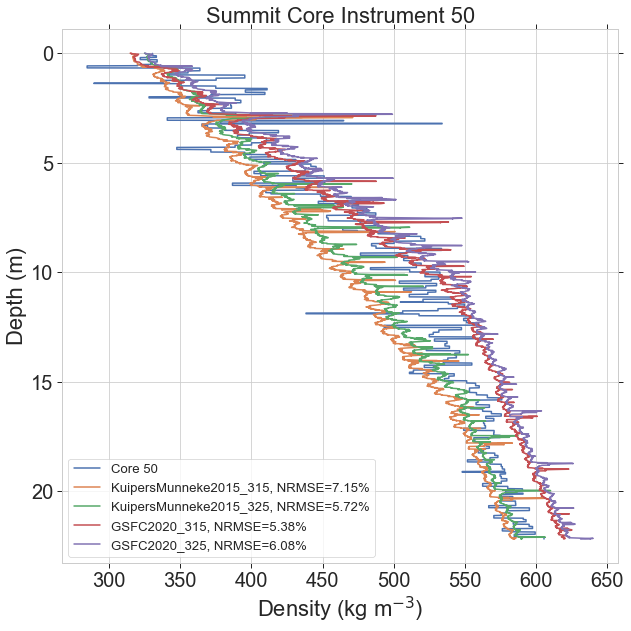

In [23]:
## Calculate NRMSE for Summit Core

Summit_cores = pd.read_pickle('FC_SummitCores.pkl')
core_numbers = Summit_cores.index.get_level_values(0).unique() #unique core numbers
core_dict = {}    
for core_num in core_numbers:
    f1,a1 = plt.subplots(figsize=(9,9))
    core_to_plot = Summit_cores.loc[core_num]
    measured_core = core_to_plot['density']
    a1.plot(measured_core, core_to_plot['depth'], label = f'Core {core_num}')
    a1.set_title(f'Summit Core Instrument {core_num}')
    a1.set_xlabel('Density (kg m$^{-3}$)')
    a1.set_ylabel('Depth (m)')

    core_maximum_depth = core_to_plot.depth.max() #(MS) let's get the maximum depth of the observed core, and we'll use that to only plot the model outputs to that depth.
        
    core_date = core_to_plot.index[0] #(MS) this is the date that the core was drilled, in YYYY-MM-DD format
    core_date_dec = toYearFraction(core_date) #(MS) this is the date that the core was drilled, in decimal date format, e.g. 2015.405
    
    modeled_cores_dict = {}

    for model_name in rd2.keys():
        modeled_cores_dict[model_name]=getModeledCores(core_date_dec,model_name)
        # print(modeled_cores_dict)
        modeled_cores_dataframe = modeled_cores_dict[model_name] #(MS) this is now a dataframe with the depth and density for a particular model run        
        modeled_cores_toplot = modeled_cores_dataframe[modeled_cores_dataframe['depth']<core_maximum_depth]
        modeled_core = modeled_cores_dataframe['density']

        #start to calculate the NRMSE
        depth_core = core_to_plot.depth.values
        depth_modeled = modeled_cores_dataframe['depth'].values
        density_modeled = modeled_cores_dataframe['density'].values
        density_interp = np.interp(depth_core,depth_modeled,density_modeled)

        rmse_max = (((density_interp - measured_core.values)**2).mean())**(1/2)
        nrmse_core = (rmse_max/measured_core.mean())*100
        nrmse_core_round = round(nrmse_core, 2)
        print(f'NRMSE Instrument {core_num}, {model_name}:')
        print(f'{nrmse_core_round} %')
        a1.plot( modeled_cores_toplot['density'], modeled_cores_toplot['depth'],label= f'{model_name}, NRMSE={nrmse_core_round}%') 
    a1.legend()
    a1.invert_yaxis() #(MS) note that I put this at the same indentation level as f1,a1 = ...
    figfilename = f'Tplus{t_adjust}_Modeled_Core_{core_num}_Depth_Density.png'
    f1.savefig(f'Summit_Figures/{figfilename}.png')